# EXTRACT 
## Fetching Data

In [27]:
""" Load in modules we will need """
import os
import gc
import numpy as np 
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from datetime import datetime as dt
load_dotenv()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#### "Reading" from Bronze Layer 

In [ ]:
"""
Retrieve all the csv file names from a given path

Parameters: 
path (string)- Path we are looking through

Returns: a list of .csv files
"""
def grab_files(path: str) -> list:
    return [file for file in os.listdir(path) if file.endswith(".csv")]

"""
Creates DataFrames for all data of a specific entity in "Bronze layer"

Parameters: 
path (string) - The "container" for the data 

Returns: a list of .csv files
"""
def gen_dfs(ospath = 'BRONZE_LAYER', path:str =''):    
    dfs = []
    try:
        data_dir = f'{os.environ[ospath]}{path + "/" if path != "" else path}'
        files = grab_files(data_dir)
        for f in files:
            df = pd.read_csv(data_dir+f)
            df.name = f.split('__')[1]
            dfs.append(df)
    except FileNotFoundError:
        print("Error with pathing")
    except:
        print('Error Occurred while extracting data from the file')
    return dfs        #create the dataframe


# TRANSFORM
## Cleaning Functions

In [ ]:
"""
Will Attempt to Drop all declared columns from a DataFrame

Parameters: 
df - a singular Data Frame
cols - a list of strings containing column attributes to be dropped

Returns: Nothing
"""
def drop_dfcols(df, cols:list):
    try:
        df.drop(columns = cols, inplace = True)
    except KeyError:
        print(f'fail to remove{cols}')

"""
Will Attempt to Drop all declared columns from a List of DataFrame

Parameters: 
df - a List of Data Frame
cols - a list of strings containing column attributes to be dropped 

Returns: Nothing
"""
def drop_dfs_col(dfs, cols: list):
    try:
        for df in dfs:
            drop_dfcols(df,cols) 
    except KeyError:
        print('no columns left')
    


In [ ]:
"""
Remove duplicate records from the DataFrame
"""
def rm_dupe(df):
    df.drop_duplicates(inplace= True)

"""
Drops the columns that have null vals
or we fill them will default values if we want
"""
def rm_nulls(df, col, default_val = None):
    if default_val:
        df[col].fillna(default_val, inplace = True)
    else:
        df.dropna(subset =[col], inplace= True) 

"""
Checks to see if any column of a DataFrame contains Nulls
-best to do this after dropping useless columns [faster]
"""
def cols_with_null(df):
    has_null = []
    for col in df.columns:
        print(f'{col} : {df[col].isnull().values.any()}')
        if df[col].isnull().values.any():
            has_null.append(col)
    return has_null

"""
Parameters:
dfs: List of DataFrames 
Return: Merged DataFrames 
"""
def merge_dfs(dfs: list):
    name_attr = dfs[0].name if hasattr(dfs[0], "name") else None
    dfs = pd.concat(dfs, ignore_index=True)        #put all the data into one table
    if name_attr:
        dfs.name = name_attr
    return dfs

In [ ]:
"""
Checks to see if a val is of type : etype

Parameters:
etype: Type 

Returns:
Boolean if it is that type
"""
def is_type(val,  etype):
    try:
        etype(val)
        return True
    except (ValueError, TypeError):
        return False
    
"""
Removes all the records that have an invalid type

Parameters:
header_df : DataFrame
col : column name to check
etype: Type 

Returns:
DataFrame with records that have valid type
"""
def rm_inval_type(df, col, etype):
    name_attr = df.name if hasattr(df, "name") else None
    df = df[df[col].apply(lambda val: is_type(val,etype))]
    if name_attr:
        df.name = name_attr
    return df

In [ ]:
"""
Removes outliers (using Interquartile range) from a given column
Parameters:
df: DataFrame
col: column to check for outliers
Returns: DataFrame with outliers removed
"""
def IQR_outlier(df, col: str):
    name_attr = df.name if hasattr(df, "name") else None
    Q1 = df[col].quantile(0.25)   
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # non_outliers = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    df_rm_outliers = df[~((df[col] < lower_bound) | (df[col] > upper_bound))]
    if name_attr:
        df_rm_outliers.name = name_attr
    return df_rm_outliers


"""
Removes outliers (using Z-score) from a given column
Parameters:
df: DataFrame
col: column to check for outliers
deviance: outlier bounds
Returns: DataFrame with outliers removed
"""
def zscore(df, col:str, deviance:int):
    col_mean = df[col].mean()
    col_std = df[col].std()
    return df[abs((df[col] - col_mean)/ col_std) <= deviance]

# LOAD
### Save into Currated layer [Silver]

In [ ]:
"""
Will file "modded_{filename}.csv"
in curated-layer directory.
If path does not exist, will create it for you.

Parameters: 
df - a Data Frame

Returns: Nothing
"""
def df2csv(df):
    year = df.name[-4:]
    type = df.name[:-5]
    path = f'../data_set/CBP_AMS/curated-layer/{year}/{type}/'          
    if not os.path.exists(path):
        os.makedirs(path)
    df.to_csv(path + f'modded_{df.name}.csv', sep='|' , index=False) 

    """
Will file "modded_{filename}.parquet"
in curated-layer directory.
If path does not exist, will create it for you.

Parameters: 
df - a Data Frame

Returns: Nothing
"""
def df2parquet(df):
    year = df.name[-4:]
    type = df.name[:-5]
    path = f'../data_set/CBP_AMS/curated-layer/{year}/{type}/'          
    if not os.path.exists(path):
        os.makedirs(path)
    df.to_parquet(path + f'modded_{df.name}.parquet', engine='pyarrow',index=False) 

##### For Current Use Case : We can reduce data overhead

In [ ]:
rm_billgen = ['house_bol_number','sub_house_bol_number', 'bill_type_code',
              'manifest_number', 'trade_update_date', 'run_date']

rm_container = ['seal_number_1', 'seal_number_2',
       'equipment_description_code','container_type', 'load_status']

rm_header  = ['carrier_code', 'vessel_country_code', 'vessel_name',
       'foreign_port_of_lading_qualifier', 'manifest_quantity', 'manifest_unit', 
       'measurement', 'measurement_unit', 'record_status_indicator',
       'place_of_receipt', 'port_of_destination', 'foreign_port_of_destination_qualifier', 
       'foreign_port_of_destination', 'conveyance_id_qualifier', 'conveyance_id', 
       'in_bond_entry_type', 'mode_of_transportation', 'secondary_notify_party_1',
       'secondary_notify_party_2', 'secondary_notify_party_3', 'secondary_notify_party_4', 
       'secondary_notify_party_5', 'secondary_notify_party_6', 'secondary_notify_party_7',
       'secondary_notify_party_8', 'secondary_notify_party_9', 'secondary_notify_party_10']

rm_tariff = ['description_sequence_number','harmonized_number', 'harmonized_weight_unit','harmonized_weight']

rm_cargodesc = [ 'description_sequence_number','description_text']


# ----------HEADER--------------

#### Cleaning Header Data

In [ ]:
"""
Convert the weight column to a universal weight unit measurement

Parameters:
header_df: DataFrame

Returns:
None
"""
def universal_unit(header_df):
    unit_weight = {
        'Kilograms': 1.0,
        'Pounds': 0.453592, 
        'Metric Ton': 1000.0, 
        'Long Ton': 1016.04691, 
        'Measurement Ton': 1.01604691
    }
    # Convert weight to kg based on weight_unit
    for unit, scale in unit_weight.items():
        header_df.loc[header_df['weight_unit'] == unit, 'weight'] *= scale
        header_df['weight_unit'] = 'Kilograms'


def is_date(val):
    try:
        dt.strptime(val, '%Y-%m-%d')
        return True
    except (ValueError, TypeError):
        return False

def rm_inval_date(df,col):
    name_attr = df.name if hasattr(df, "name") else None
    df = df[df[col].apply(is_date)]
    if name_attr:
        df.name = name_attr
    return df

"""
removes the records that have dates that are not in the scope of this year
"""
def date_outlier(df):
    name_attr = df.name if hasattr(df, "name") else None
    year = int(df.name[-4:])
    df['estimated_arrival_date'] = pd.to_datetime(df['estimated_arrival_date'], format='%Y-%m-%d')
    df['actual_arrival_date'] = pd.to_datetime(df['actual_arrival_date'], format='%Y-%m-%d')
    df = df[df['actual_arrival_date'].dt.year <= year]   # we are not in the future!!!
    df = df[(abs(df['estimated_arrival_date'].dt.year - year) <= 5)]
    df = df[(abs(df['actual_arrival_date'].dt.year - year) <= 5)]
    if name_attr:
        df.name = name_attr
    return df
    


#### Load in HEADER Data

In [ ]:
# Currated layer only requires : container |  header  |  tariff   |   billgen   
dfs = gen_dfs(path='header')
dfs[0]

In [ ]:
# Drop columns we will not be using
drop_dfs_col(dfs, rm_header)

In [ ]:
# Merge the dataframes into one 
dfs = merge_dfs(dfs)

In [ ]:
# Drop the duplicate records
rm_dupe(dfs)



#### Removal of any irregular data in the record

In [ ]:
# Check to make sure there are no null values 😀
for col in cols_with_null(dfs):
    rm_nulls(dfs, col)
# Header does not need to deal with any Nulls 🎉

In [ ]:
# check the type of weight columns 
dfs = rm_inval_type(dfs, 'weight', int)

In [ ]:
# check the type of port
dfs = rm_inval_type(dfs, 'port_of_unlading', str)

In [ ]:
# check the type of port
dfs = rm_inval_type(dfs, 'foreign_port_of_lading', str)

In [ ]:
# check the type of unit
dfs = rm_inval_type(dfs, 'weight_unit', str)

In [ ]:
# Removes any invalid date in this col
dfs = rm_inval_date(dfs, 'estimated_arrival_date')

In [ ]:
# Removes any invalid date in this col
dfs = rm_inval_date(dfs, 'actual_arrival_date')

In [ ]:
# Remove out the Outliers
dfs = IQR_outlier(dfs, 'weight')

In [ ]:
# remove any date outliers 
dfs = date_outlier(dfs)

In [ ]:
# Clean the weight unit to a singular unit ( Kilogram )
universal_unit(dfs)

In [ ]:
# Cleaned up Header Data -> Store into "Silver Layer" 
df2parquet(dfs)

# ----------BILL GEN--------------

In [ ]:
# Currated layer only requires : container |  header  |  tariff   |   billgen   
dfs = gen_dfs(path='billgen')
dfs[0]

In [ ]:
# Drop columns we will not be using
drop_dfs_col(dfs, rm_billgen)

In [ ]:
# Merge the dataframes into one  
dfs = merge_dfs(dfs)

In [ ]:
# Drop the duplicate records  
rm_dupe(dfs)

In [ ]:
# remove any null values
for col in cols_with_null(dfs):
    rm_nulls(dfs, col)

In [ ]:
# Cleaned up Bill Gen Data -> Store into "Silver Layer" 
df2parquet(dfs)

# ----------CONTAINER--------------

In [ ]:
def rm_box_outlier(df):
    name_attr = df.name if hasattr(df, "name") else None
    df = df[(df['container_length'] != 0) & (df['container_width'] != 0) & (df['container_height'] != 0)]
    if name_attr:
        df.name = name_attr
    return df

In [ ]:
# Currated layer only requires : container |  header  |  tariff   |   billgen   
dfs = gen_dfs(path='container')
dfs[0]

In [ ]:
# Drop columns we will not be using
drop_dfs_col(dfs, rm_container)

In [ ]:
# Merge the dataframes into one    30635677 rows × 6 columns   27234627 rows × 6 columns
dfs = merge_dfs(dfs)

In [ ]:
# Drop the duplicate records  
rm_dupe(dfs)

In [ ]:
# remove any null values
for col in cols_with_null(dfs):
    rm_nulls(dfs, col)

In [ ]:
# Removes any invalid length in this col
dfs = rm_inval_type(dfs, 'container_length', int)

In [ ]:
# Removes any invalid height in this col
dfs = rm_inval_type(dfs, 'container_height', int)

In [ ]:
# Removes any invalid width in this col
dfs = rm_inval_type(dfs, 'container_width', int)

In [ ]:
dfs = rm_box_outlier(dfs)

In [ ]:
# grouped_counts = dfs.groupby(['container_length', 'container_height', 'container_width']).size().reset_index(name='counts')


In [ ]:
# grouped_counts.sort_values('counts')

In [ ]:
df2parquet(dfs)

# ------Tariff + Cargo Desc------

#### Load in Tariff

In [ ]:
def rm_cgd_outliers(df):
    name_attr = df.name if hasattr(df, "name") else None
    df = df[(df['piece_count'] != 0)]
    if name_attr:
        df.name = name_attr
    return df

def rm_tariff_outliers(df):
    name_attr = df.name if hasattr(df, "name") else None
    df = df[(df['harmonized_value'] > 0)]
    if name_attr:
        df.name = name_attr
    return df

In [ ]:
# Currated layer only requires : container |  header  |  tariff   |   billgen   |   cargodesc
tdfs = gen_dfs(path='tariff')
tdfs[0]

In [ ]:
# Drop columns we will not be using
drop_dfs_col(tdfs, rm_tariff)

In [ ]:
# Merge the dataframes into one   
tdfs = merge_dfs(tdfs)

In [ ]:
# Drop the duplicate records  
rm_dupe(tdfs)

In [ ]:
# remove any null values
for col in cols_with_null(tdfs):
    rm_nulls(tdfs, col)

In [ ]:
# check the type of piece
tdfs = rm_inval_type(tdfs,'harmonized_value', int)

In [ ]:
# remove value outliers
tdfs = rm_tariff_outliers(tdfs)

In [ ]:
tdfs = IQR_outlier(tdfs, 'harmonized_value')

#### Load in Cargo Desc

In [ ]:
# Currated layer only requires : container |  header  |  tariff   |   billgen   |   cargodesc
dfs = gen_dfs(path='cargodesc')
dfs[0]

In [ ]:
# Drop columns we will not be using
drop_dfs_col(dfs, rm_cargodesc)

In [ ]:
# Merge the dataframes into one    30635677 rows × 6 columns   27234627 rows × 6 columns
dfs = merge_dfs(dfs)

In [ ]:
# Drop the duplicate records  
rm_dupe(dfs)

In [ ]:
# remove any null values
for col in cols_with_null(dfs):
    rm_nulls(dfs, col)

In [ ]:
# check the type of piece
dfs = rm_inval_type(dfs,'piece_count', int)

In [ ]:
dfs = rm_cgd_outliers(dfs)
# done cleaning cargo desc

In [ ]:
mdfs = pd.merge(dfs,tdfs, on=['identifier', 'container_number'])
mdfs.name = tdfs.name[:-5] + '_' + dfs.name[:-5] + '_' + tdfs.name[-4:]

In [ ]:
# mdfs['tot_cost'] = mdfs['piece_count'] * mdfs['harmonized_value']       # not necessary for silver layer

In [ ]:
df2parquet(mdfs)

# Store Data Into DB

In [2]:
import pyodbc
from sqlalchemy import create_engine
import urllib

def grab_files(path: str) -> list:
    file=[file for file in os.listdir(path) if file.endswith(".parquet")]
    return file[0]

def load_pq_df(model):
    path = f'{os.environ['SILVER_LAYER']}{model}/'
    file = grab_files(path)
    df = pd.read_parquet(path + file)
    return df

In [3]:
params = urllib.parse.quote_plus(r'DRIVER={ODBC Driver 17 for SQL Server};'
                                 r'SERVER=DESKTOP-N9SA336;'
                                 r'DATABASE=BastionSLA;'
                                 r'Trusted_Connection=yes;')
engine = create_engine(f"mssql+pyodbc:///?odbc_connect={params}")

In [5]:
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};Server={DESKTOP-N9SA336};Database=;Trusted_Connection=yes;')
cursor = conn.cursor() # Cursors are database level objects that let your query a database multiple times - Think of it as a pointer to a row


#### Create a Bastion Analytic DB 

In [6]:
# Create a DB as Silver Layer Storage
db_name = "BastionSLA"
cursor.execute(f"""
        IF NOT EXISTS (SELECT * FROM sys.databases WHERE name = '{db_name}')
        BEGIN
            CREATE DATABASE {db_name}
        END
        """)

In [7]:
cursor.execute('use BastionSLA')

### Load in Bill Gen Data

In [63]:
df = load_pq_df('billgen')

In [68]:
table_billgen = 'billgen'
try:
    create_table_query = f"""
                    IF NOT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_NAME = '{table_billgen}')
                    BEGIN
                        CREATE TABLE {table_billgen} (
                            identifier BIGINT NOT NULL,
                            master_bol_number VARCHAR(255),
                            voyage_number VARCHAR(50)
                        )
                    END
                    """
    cursor.execute(create_table_query)
    conn.commit()
    print('Table has been created')
except:
    print('Alrdy exist or something went wrong')

Table has been created


In [69]:
# WRITE BILLGEN to DATABASE
df.to_sql(table_billgen, engine, if_exists='append', index=False, schema='dbo')

412

# ------ Load Container -----

In [8]:
df = load_pq_df('container')

In [12]:
table_container = 'container'
try:
    create_table_query = f"""
                    IF NOT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_NAME = '{table_container}')
                    BEGIN
                        CREATE TABLE {table_container} (
                            identifier BIGINT, 
                            container_number VARCHAR(50), 
                            container_length INT,
                            container_height INT,
                            container_width INT,
                            type_of_service VARCHAR(255) 
                        )
                    END
                    """
    cursor.execute(create_table_query)
    conn.commit()
    print('Table has been created')
except:
    print('Alrdy exist or something went wrong')

Table has been created


In [13]:
# WRITE BILLGEN to DATABASE
df.to_sql(table_container, engine, if_exists='append', index=False, schema='dbo')

70

# ------ Load Header -----

In [14]:
df = load_pq_df('header')

In [16]:
table_header = 'header'
try:
    create_table_query = f"""
                    IF NOT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_NAME = '{table_header}')
                    BEGIN
                        CREATE TABLE {table_header} (
                            identifier BIGINT,
                            port_of_unlading VARCHAR(100),
                            estimated_arrival_date DATE,
                            foreign_port_of_lading VARCHAR(100),
                            weight INT,
                            weight_unit VARCHAR(10),
                            actual_arrival_date DATE
                        )
                    END
                    """
    cursor.execute(create_table_query)
    conn.commit()
    print('Table has been created')
except:
    print('Alrdy exist or something went wrong')

Table has been created


In [17]:
# WRITE HEADER to DATABASE
df.to_sql(table_header, engine, if_exists='append', index=False, schema='dbo')

17

# ------ Load Tariff_Cargodesc -----

In [18]:
df = load_pq_df('tariff_cargodesc')

In [20]:
table_tfcargo = 'tariff_cargodesc'
try:
    create_table_query = f"""
                    IF NOT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_NAME = '{table_tfcargo}')
                    BEGIN
                        CREATE TABLE {table_tfcargo} (
                            identifier BIGINT,
                            container_number VARCHAR(50),
                            piece_count DECIMAL(10, 2),
                            harmonized_value DECIMAL(15, 2)
                        )
                    END
                    """
    cursor.execute(create_table_query)
    conn.commit()
    print('Table has been created')
except:
    print('Alrdy exist or something went wrong')

Table has been created


In [21]:
# WRITE HEADER to DATABASE
df.to_sql(table_tfcargo, engine, if_exists='append', index=False, schema='dbo')

121

# USE CASE


In [24]:
#Q1  Frequency for each type of service  - container table 
query = """
        SELECT type_of_service, COUNT(*) as service_count
        FROM Container
        GROUP BY type_of_service
        """
df_svc_type_count = pd.read_sql_query(query, engine)

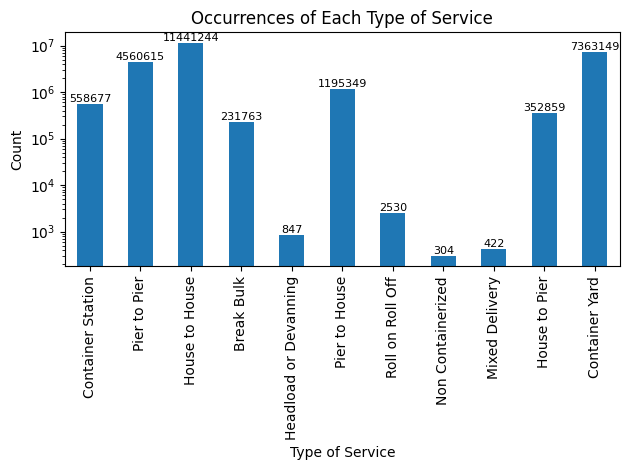

In [36]:
ax = df_svc_type_count.plot(kind='bar', x='type_of_service', y='service_count', legend=None)
plt.xlabel('Type of Service')
plt.ylabel('Count')
plt.yscale('log')     
plt.title('Occurrences of Each Type of Service')
plt.tight_layout()  
for i, v in enumerate(df_svc_type_count['service_count']):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=8)
plt.show()

# Majority of shipments are customer buying from merchant shipping straight to their doors

C:\Users\alvin\AppData\Local\Temp\ipykernel_18412\4176244399.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_val_vs_weight.groupby('weight_bin')['total_value'].mean().reset_index()


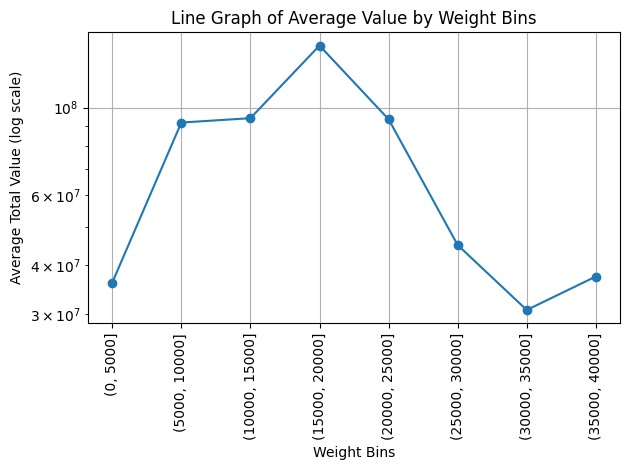

In [46]:
# Q2 Weight Group proportional to Value for containers? 
# header : weight  => tot_val

query = """
        SELECT 
            h.weight,
            SUM(c.piece_count * c.harmonized_value) AS total_value
        FROM 
            header AS h
        JOIN 
            tariff_cargodesc AS c ON h.identifier = c.identifier
        GROUP BY 
            h.weight
        """
df_val_vs_weight = pd.read_sql_query(query, engine)



df_val_vs_weight['weight_bin'] = pd.cut(df_val_vs_weight['weight'], bins=np.arange(0, df_val_vs_weight['weight'].max(), 5000))
grouped = df_val_vs_weight.groupby('weight_bin')['total_value'].mean().reset_index()

# Plotting the line graph
plt.plot(grouped['weight_bin'].astype(str), grouped['total_value'], marker='o')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.yscale('log')  # Apply logarithmic scale to the y-axis
plt.xlabel('Weight Bins')
plt.ylabel('Average Total Value (log scale)')
plt.title('Line Graph of Average Value by Weight Bins')
plt.grid(True)
plt.tight_layout()
plt.show()


In [55]:
#Q3  TOTAL weight of cargo for each port?   header
query = """
        SELECT port_of_unlading, SUM(weight) AS total_weight
        FROM header
        GROUP BY port_of_unlading
        ORDER BY total_weight DESC 
        """
df_port_weights = pd.read_sql_query(query, engine)

In [59]:
df_port_weights.sort_values(by='total_weight', ascending=False)
# Most weight unloaded at cali

,port_of_unlading,total_weight
0,"Los Angeles, California",34754068975
1,"New York/Newark Area, Newark, New Jersey",34460307660
2,"Long Beach, California",28117239733
3,"Savannah, Georgia",14878031492
4,"Houston, Texas",12711507128
...,...,...
199,"Orlando, Florida",237
200,"San Joaquin River, California",200
201,"Coos Bay, Oregon",190
202,"Detroit Metropolitan Airport, Michigan",40


In [63]:
# Q4 : Which ports were shipped from the most?
query = """
        SELECT foreign_port_of_lading, COUNT(*) AS total_appearances
        FROM header
        GROUP BY foreign_port_of_lading
        ORDER BY total_appearances DESC;
        """
df_shipped_port = pd.read_sql_query(query, engine)

In [64]:
df_shipped_port

,foreign_port_of_lading,total_appearances
0,"Shanghai ,China (Mainland)",2176849
1,"Yantian,China (Mainland)",2000710
2,"Ningpo ,China (Mainland)",1232578
3,"Pusan,South Korea",1145675
4,"Kaohsiung,China (Taiwan)",698784
...,...,...
1082,"Kalamata ,Greece",1
1083,"Victoria,Cameroon",1
1084,"Barletta,Italy",1
1085,"Kiire,Japan",1


In [66]:
# Q5 : Which ports received the most shipments?
query = """
        SELECT port_of_unlading, COUNT(*) AS total_appearances
        FROM header
        GROUP BY port_of_unlading
        ORDER BY total_appearances DESC;
        """
df_received_port = pd.read_sql_query(query, engine)

In [67]:
df_received_port

,port_of_unlading,total_appearances
0,"Los Angeles, California",3652643
1,"New York/Newark Area, Newark, New Jersey",3133958
2,"Long Beach, California",2764970
3,"Savannah, Georgia",1104332
4,"Tacoma, Washington",946334
...,...,...
199,"Danville, Washington",1
200,"Gary, Indiana",1
201,"Bangor, Maine",1
202,"San Antonio, Texas",1


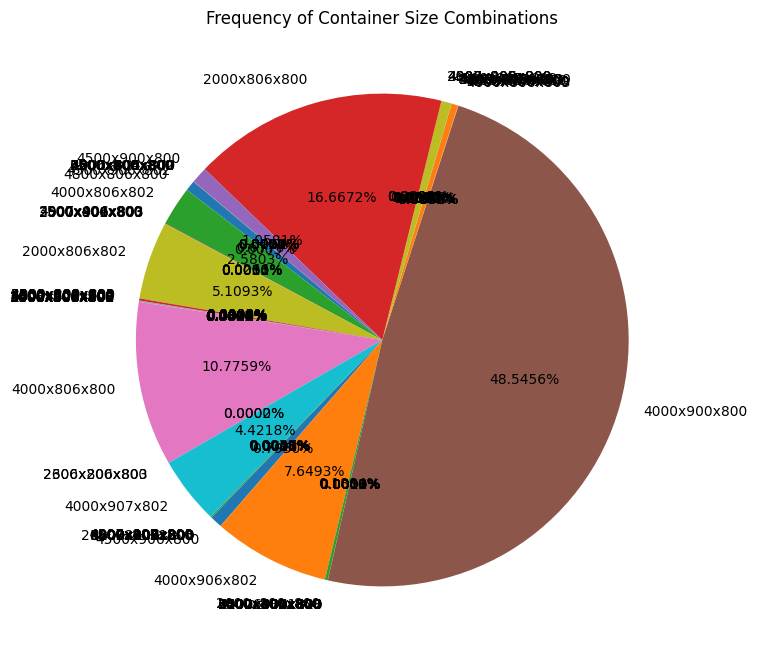

In [75]:
# Q6 : Frequency of Container Sizes used?
query = """
        SELECT container_length, container_height, container_width, COUNT(*) AS frequency
        FROM container
        GROUP BY container_length, container_height, container_width;
        """
df_container_freq = pd.read_sql_query(query, engine)
labels = [f'{row.container_length}x{row.container_height}x{row.container_width}' for index, row in df_container_freq.iterrows()]
sizes = df_container_freq['frequency'].tolist()

# Creating the pie chart
plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, autopct='%1.4f%%', startangle=140)
plt.title('Frequency of Container Size Combinations')
plt.show()

In [77]:
df_container_freq.sort_values(by='frequency', ascending= False)

,container_length,container_height,container_width,frequency
65,4000,900,800,12479998
83,2000,806,800,4284757
36,4000,806,800,2770236
51,4000,906,802,1966473
18,2000,806,802,1313479
...,...,...,...,...
82,4300,405,800,1
70,4800,906,800,1
76,4300,806,800,1
72,4500,400,800,1


In [79]:
# Q7 : How frequent were delays?
query = """ 
        SELECT COUNT(*) AS total_delays
        FROM header
        WHERE actual_arrival_date > estimated_arrival_date;
        """
df_delay_freq = pd.read_sql_query(query, engine)

In [80]:
df_delay_freq

,total_delays
0,9388178


In [81]:
# Q8 : Which ports had the most delays?
query = """ 
        SELECT port_of_unlading, COUNT(*) AS delay_count
        FROM header
        WHERE actual_arrival_date > estimated_arrival_date
        GROUP BY port_of_unlading
        ORDER BY delay_count DESC;
        """
df_port_delay_freq = pd.read_sql_query(query, engine)

In [82]:
df_port_delay_freq

,port_of_unlading,delay_count
0,"New York/Newark Area, Newark, New Jersey",1749436
1,"Los Angeles, California",1738062
2,"Long Beach, California",1605636
3,"Savannah, Georgia",767797
4,"Tacoma, Washington",577029
...,...,...
188,"Oakland/Pontiac Airport, Detroit, Michigan",1
189,"Newport, Oregon",1
190,"Maida, North Dakota",1
191,"Cruz Bay, Virgin Islands",1


In [85]:
# Q9 : Which months did these delays occur in?
query = """ 
        SELECT DATEPART(MONTH, actual_arrival_date) AS delay_month, COUNT(*) AS delay_count
        FROM header
        WHERE actual_arrival_date > estimated_arrival_date
        GROUP BY DATEPART(MONTH, actual_arrival_date)
        ORDER BY delay_count DESC;
        """
df_monthly_delay = pd.read_sql_query(query, engine)

In [86]:
df_monthly_delay
# surprisingly decemeber is not # 1

,delay_month,delay_count
0,1,1168123
1,2,906155
2,3,792858
3,12,768864
4,5,763836
5,4,754733
6,9,750826
7,7,738884
8,10,732099
9,8,694175
